# **ESPIDAM: SIR Example**

***Authors: Sebastiaan Weytjens, Bram Silue, Pieter Libin, Niel Hens***

### **How to Run**
If you're having trouble running this code on your local machine, please open and run this notebook in Colab:

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/plibin/espidam-25/blob/main/sir/1_sir.ipynb)

We define some helper code that allows this notebook to run in both local environments and Google Colab:

In [1]:
import os
import urllib.request

def is_running_in_colab() -> bool:
    """
    Returns if the code is running inside Google Colab.

    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

def download_file(filepath: str, 
                  url: str) -> None:
    """
    Download a file from a URL if it does not exist locally. This is only 
    performed when running inside Google Colab.

    Arguments
    ---------
    filepath :  The local path (including subdirectories) where the file should be saved.
    url      :  The direct URL to download the file from.

    """
    if is_running_in_colab() and not os.path.exists(filepath):
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        print(f"Downloading {filepath} from {url}")
        urllib.request.urlretrieve(url, filepath)

For Colab runs, we download the necessary files (i.e., helper functions, images, etc.):

In [2]:
if is_running_in_colab():
    download_file(filepath='img/sir_diagram.png', url=f'https://raw.githubusercontent.com/plibin/espidam-25/main/sir/img/sir_diagram.png')
    download_file(filepath='utils/sir_helpers.py', url=f'https://raw.githubusercontent.com/plibin/espidam-25/main/sir/utils/sir_helpers.py')

### **SIR Models: Theory**
The diagram below shows the SIR model. The diagram shows the 3 compartments, S, I and R, and the rates between them. The rate between S and I is also refered to as the force of infection (FOI).

![The diagram of an SIR model.](img/sir_diagram.png)


To solve this model deterministically, we can formulate it as a set of Ordinary Differential Equations (ODEs),


$
\begin{aligned}
\frac{{dS}}{{dt}} &= -\beta \cdot I / N \cdot S \\
\frac{{dI}}{{dt}} &= \beta \cdot I / N \cdot S - \gamma \cdot I \\
\frac{{dR}}{{dt}} &= \gamma \cdot I
\end{aligned}
$

Alternatively, we can solve this model stochastically using a Binomial Chain [1], as shown below.

First, the new individuals in $I$ and $R$ are calculated, where $p^{S \rightarrow I}(t)$ and $p^{I \rightarrow R}(t)$ are probabilities of an individual transitioning from $S$ to $I$ or $I$ to $R$, respectively.

$
\begin{aligned}
I_{\text {new }} & \sim \operatorname{Binomial}\left(p^{S \rightarrow I}(t), S(t)\right) \\
R_{\text {new }} & \sim \operatorname{Binomial}\left(p^{I \rightarrow R}(t), I(t)\right) \\
\end{aligned}
$

The rate can be converted to a probability (e.g. $p^{S \rightarrow I}(t)$) as follows: 

$
\begin{aligned}
p &= 1-e^{-\text{rate}*dt}
\end{aligned}
$

Then, all compartments are updated accordingly.

$
\begin{aligned}
S(t+1) &= S(t) - I_{\text {new }} \\
I(t+1) &= I(t) + I_{\text {new }} - R_{\text {new }} \\
R(t+1) &= R(t) + R_{\text {new }}
\end{aligned}
$

[1]: Abrams, S., Wambua, J., Santermans, E., Willem, L., Kuylen, E., Coletti, P., Libin, P., Faes, C., Petrof, O., Herzog, S. A., Beutels, P., & Hens, N. (2021). Modelling the early phase of the Belgian COVID-19 epidemic using a stochastic compartmental model and studying its implied future trajectories. In Epidemics (Vol. 35, p. 100449). Elsevier BV. https://doi.org/10.1016/j.epidem.2021.100449

### **SIR Models: Code**

#### **Dependencies**
First, make sure to install miniconda and the necessary libraries as specified in [`README.md`](README.md). After that, we import the necessary libraries and dependencies as follows:

In [ ]:
from utils.sir_helpers import *

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

We also define a helper function that converts a rate to a probability:

In [4]:
def rate_to_p(rate: float, dt: float) -> float:
    """
    Converts a continuous rate into the probability of occurrence over a time interval.

    Arguments
    ---------
    rate :  The continuous event rate (e.g., hazard or transition rate).
    dt   :  The duration of the time interval.

    Returns
    -------
    The probability of the event occurring during the interval.
    
    """
    return 1 - math.exp(-rate * dt)


#### **Model Description**
We describe the model:

In [5]:
# Compartments.
compartments = {
    "S": [],
    "I": [],
    "R": [],
}

# Transition rates.
def foi(i: int, params: dict, N: int) -> float:
    """
    Computes the force of infection.

    Arguments
    ---------
    i      :  The number of infectious individuals.
    params :  The dictionary containing model parameters (expects key 'beta').
    N      :  The total population size.

    Returns
    -------
    The infection rate per susceptible individual.

    """
    return i * params["beta"] / N


def i_r(params: dict) -> float:
    """
    Computes the recovery rate.

    Arguments
    ---------
    params :  The dictionary containing model parameters (expects key 'gamma').

    Returns
    -------
    The recovery rate.

    """
    return params["gamma"]


def initialise_modelstate(modelstate: dict, seeds: int, N: int) -> dict:
    """
    Initialises the model state with given population and seed infections.

    Arguments
    ---------
    modelstate :  A dictionary to hold compartment values over time.
    seeds      :  The initial number of infected individuals.
    N          :  The total population size.

    Returns
    -------
    modelstate :  The updated model state dictionary.
    
    """
    modelstate["S"] = [N - seeds]
    modelstate["I"] = [seeds]
    modelstate["R"] = [0]

    return modelstate


#### **Solvers for the Model**
We solve the model either deterministically using ordinary differential equations (ODEs), or stochastically using a Binomial Chain simulation.

We define the ODE solver as follows:

In [6]:
def ode_system(y0: tuple, t: float, parameters: dict) -> tuple:
    """
    Defines the ODE system for the SIR model.

    Arguments
    ---------
    y0         :  A tuple of initial values for (S, I, R).
    t          :  The current time point (unused but required by `odeint`).
    parameters :  A dictionary containing 'disease_params' and population size 'N'.

    Returns
    -------
    The derivatives (dS, dI, dR) as a tuple.
    
    """
    params = parameters["disease_params"]
    N = parameters["N"]

    s, i, r = y0
    ds, di, dr = 0, 0, 0

    # Calculate infection transitions.
    diff = s * foi(i, params, N)
    ds -= diff
    di += diff

    # Calculate recovery transitions.
    diff = i * i_r(params)
    di -= diff
    dr += diff

    return ds, di, dr


def ode_solver(model_state: dict, end_t: int, params: dict, N: int) -> dict:
    """
    Solves the SIR model using ordinary differential equations.

    Arguments
    ---------
    model_state :  The initial state of the compartments.
    end_t       :  The number of time steps to simulate.
    params      :  A dictionary of model parameters.
    N           :  The total population size.

    Returns
    -------
    new_model_state :  The model state over time for compartments S, I, and R.

    """
    all_parameters = {
        "disease_params": params,
        "N": N,
    }

    # Initial conditions and time vector.
    y0 = (model_state["S"][0], model_state["I"][0], model_state["R"][0])
    t = np.linspace(0, end_t, end_t)

    # Solve the ODE system.
    ret = odeint(ode_system, y0, t, args=(all_parameters,))
    s, i, r = ret.T

    new_model_state = {
        "S": list(s),
        "I": list(i),
        "R": list(r),
    }

    return new_model_state

Next, we define the Binomial Chain solver as follows:

In [7]:

def binom_solver(model_state: dict, end_t: int, params: dict, N: int, iterations: int) -> dict:
    """
    Simulates the SIR model using a binomial chain approach.

    Arguments
    ---------
    model_state :  The initial state of the compartments.
    end_t       :  The number of time steps (days) to simulate.
    params      :  A dictionary of model parameters.
    N           :  The total population size.
    iterations  :  The number of stochastic simulations to run.

    Returns
    -------
    model_states :  A dictionary of trajectories over time for each compartment across iterations.
    
    """
    model_states = {
        "S": [],
        "I": [],
        "R": [],
    }

    # Simulate multiple stochastic trajectories.
    for _ in range(iterations):
        s = [model_state["S"][0]]
        i = [model_state["I"][0]]
        r = [model_state["R"][0]]

        # Simulate 10 steps per day for better resolution.
        for t in range(1, end_t * 10):
            i_new = np.random.binomial(s[t - 1], rate_to_p(foi(i[t - 1], params, N), 1 / 10))
            r_new = np.random.binomial(i[t - 1], rate_to_p(i_r(params), 1 / 10))

            s.append(s[t - 1] - i_new)
            i.append(i[t - 1] + i_new - r_new)
            r.append(r[t - 1] + r_new)

        # Downsample to daily resolution.
        indices = [index for index in range(0, end_t * 10, 10)]
        model_states["S"].append([s[index] for index in indices])
        model_states["I"].append([i[index] for index in indices])
        model_states["R"].append([r[index] for index in indices])

    return model_states


#### **Model Parameters**
We can now set our model parameters:

In [ ]:
# Population and initial conditions.
N = 1_000_000   # total population
seeds = 10      # initial number of infected individuals

# Disease parameters.
R0 = 1.5        # basic reproduction number
gamma = 1/3     # recovery rate (1 / infectious period)
params = {
    "beta": R0 * gamma,  # transmission rate
    "gamma": gamma,      # recovery rate
}

# Simulation settings.
end_t = 150  # number of days to simulate


#### **Plotting**
We can now plot our simulations. We consider both deterministic and stochastic results.

**Plotting deterministic results**

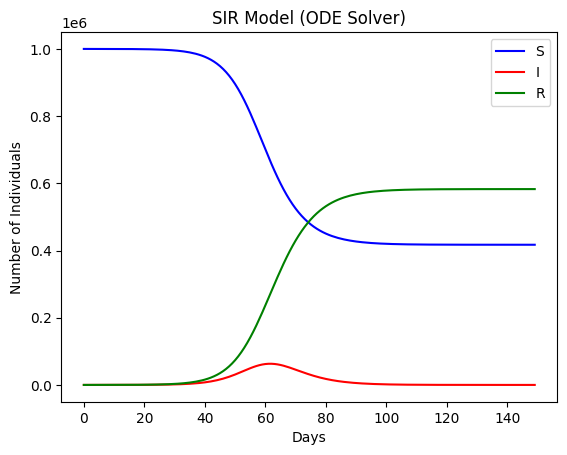

In [9]:
modelstate = initialise_modelstate(compartments, seeds, N)
results = ode_solver(modelstate, end_t, params, N)

plot_ODE(results, "SIR Model (ODE Solver)")

**Plotting stochastic results**

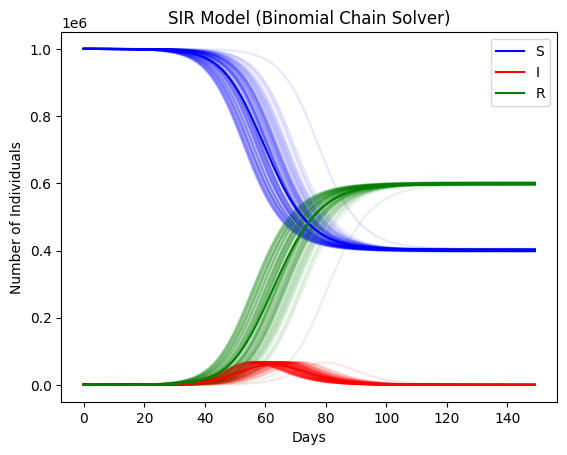

In [10]:
modelstate = initialise_modelstate(compartments, seeds, N)
results = binom_solver(modelstate, end_t, params, N, 100)

plot_binom(results, "SIR Model (Binomial Chain Solver)")

Compare the results of the ODE with the means of the stochastic trajectories. Why are there differences?

**Comparing various $R_0$**

$R_0$, also known as the basic reproduction number, represents the average number of secondary infections caused by a single infected individual in a completely susceptible population.

To calculate $R_0$ in this simple SIR model, we can use this formula:

$
R_0 = \beta / \gamma
$

In this example, we will compare trajectories for various $R_0$.

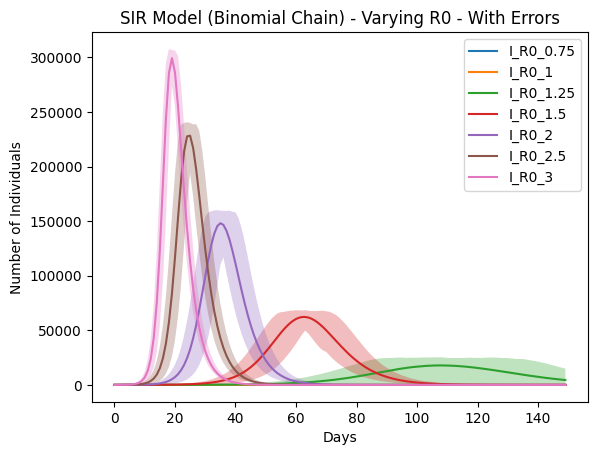

In [ ]:
results = {}

modelstate = initialise_modelstate(compartments, seeds, N)

for R0 in [0.75, 1, 1.25, 1.5, 2, 2.5, 3]:
    params = {
        "beta":  R0 * gamma,  # transmission rate
        "gamma": gamma        # recovery rate
    }

    results[R0] = binom_solver(modelstate, end_t, params, N, 100)

plot_binom_R0s(results, "SIR Model (Binomial Chain) - Varying R0 - With Errors")